# Import Packages

In [51]:
import pandas as pd
import seaborn as sb
import os
import math
from matplotlib import pyplot as plt
import scipy
import pingouin as pg
import scipy.stats as stats
import statsmodels
import numpy as np
from math import sqrt
from statsmodels.stats.power import TTestIndPower
from scipy.stats import binom_test
from analysis_helpers import *
from  matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
import pingouin as pg
import scipy
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sb.set(font_scale=2)
sb.set_style("white")

# Concatenate data 

In [52]:
file_ID = ['MISMATCH',                     'SCRAMBLE_PI',                                'SCRAMBLE_ISO',                              'FLIP',                            'FOR_REV_PILOT',                           'FOR_REV_ISOLATED']      
tag     = ['Mismatched Image', 'Scrambled Order versus Veridical (Image)','Scrambled Order versus Veridical (Black)','Horizontal Flip versus Veridical (Black)','Reverse Order versus Veridical (Image)','Reverse Order versus Veridical (Black)']
path    = 'exp1-6_data' #'../pilot_data'
data_d  = {} 

for t in tag:
    data_d[t] = []


for x in os.listdir(path):
    
    if x != '.DS_Store' and x!='.ipynb_checkpoints' and 'csv' in x:
        df = pd.read_csv(path+'/'+x)
        
        for a,b in zip(file_ID,tag):
            if a in x:
                df['version'] = b
                data_d[b].append(df)
                

In [53]:
concat_list = []
for k in data_d:
    concat_list.append(data_d[k])
    
for idx,x in enumerate(concat_list):
    concat_list[idx]=pd.concat([organize_data(y) for y in x])
    
full_data = pd.concat(concat_list)
#full_data.to_csv('data_temps/full_data.csv')

#### Prep extra subject

Prep the data for one subject whose data file was saved in a different format

Note: the 'proportion correct' column for this subject was added manually by author KZ

In [54]:
subject = pd.read_csv("exp1-6_data/problem_subject.csv")

In [55]:
subject['version'] = 'Scrambled Order versus Veridical (Black)'
subject['Percent Correct']    = subject['proportion_correct']*100

In [56]:
s = subject['responses']

l = list(s)
l_new = ['missing' if x is np.nan else x for x in l]

final_confidence = []

for a in l_new:
    if type(a)==str:
        if 'confidence":' in a:
            final_confidence.append(int(a[-2]))
        else:
            final_confidence.append(np.nan)
    else:
        final_confidence.append(np.nan)

final_confidence = final_confidence[1:]
final_confidence.append(np.nan) #.append(np.nan)

subject['Confidence']=final_confidence
subject['confidence']=final_confidence

#### Use this code to check if any columns are different between this "problem subject" df and the main data df

In [57]:
# sub_cols = list(subject.columns) 
# full_cols = list(full_data.columns) 

# # which columns are in full data that aren't in the html subject
# for x in full_cols:
#     if x not in sub_cols:
#         print(x)

# Compile data

Add the single subject to the rest of the subject data

In [58]:
full_data = pd.concat([full_data,subject])
print(full_data.shape)

(72373, 22)


# Make "location" df 
Make a dataframe with the number of attention locations in each video stimulus

In [59]:
image_csv = []

for x in os.listdir('/Users/kirstenziman/Desktop/Desktop/DIDEC_entire_corpus/analysis_3/stim_sets/STIM_SET_1'):
    if x[-3:]=='csv':
        image_csv.append(x)
        
dfs = [pd.read_csv('/Users/kirstenziman/Desktop/Desktop/DIDEC_entire_corpus/analysis_3/stim_sets/STIM_SET_1'+'/'+x) for x in image_csv if 'veridical' in x]

# dataframe with relevant metadata for videos in this stim set
blob_df = pd.concat(dfs)

# Figure 2: Experiment 1 Figure & Statistics


########## Scrambled Order versus Veridical (Image) #############



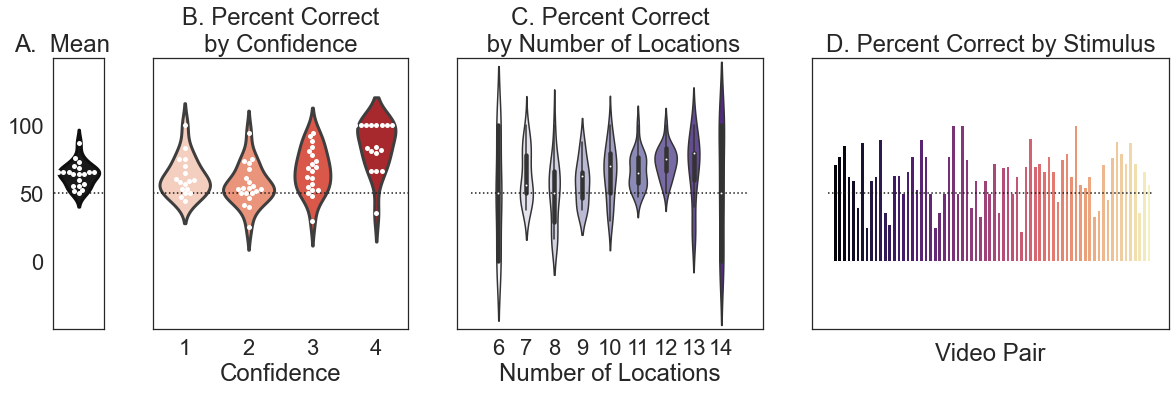



################# SUMMARY STATS ##################

Mean: 63.92857142857142
Standard Error: 1.9878119498616784

Mean t-test: TtestResult(statistic=7.006986465465527, pvalue=1.1313134375508361e-06, df=19)



################# LOCATIONS ANOVA ################

            Source  ddof1  ddof2         F    p-unc  p-GG-corr       np2  \
0  Number of blobs      8    152  2.025249  0.04696   0.126068  0.096325   

        eps  sphericity   W-spher       p-spher  
0  0.346112       False  0.002416  1.722102e-07  



########### CONFIDENCE SUMMARY STATS ############

Confidence of 1, Mean: 62.40627044043998
Conf 1, t-test: TtestResult(statistic=3.5446437510857565, pvalue=0.0026968539792182364, df=16)
Conf 1, Standard Error: 0.03500004883887084

Confidence of 4, Mean: 85.03579647451438
Conf 4 t-test: TtestResult(statistic=7.9117805951798355, pvalue=6.401549594904082e-07, df=16)
Conf 4, Standard Error: 0.044283073895981837



################# CONFIDENCE ANOVA ###############

       Source  d

In [108]:
sb.set(font_scale=2)
sb.set_style("white")

full_data['Percent Correct'] = full_data['proportion_correct']*100
full_data['Confidence']      = full_data['confidence']+1

#for x in full_data['version'].unique():
    
for x in ['Scrambled Order versus Veridical (Image)']:
    
    print(); print('########## '+x+' #############'); print()
    
    if x in ['Scrambled Order versus Veridical (Image)']:
    #if x not in ['ForwardReverse_full_image','ForwardReverse_blobbified_black']:
        
        # get the data for this version
        this_data = full_data[full_data['version'] == x]
        mean_plot = this_data.groupby('ID', as_index=False).mean()
        conf_plot = this_data.groupby(['ID','confidence'], as_index=False).mean()
        
        conf_plot['Confidence'] = conf_plot['Confidence'].astype(int)
                
        # make the subplots        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, gridspec_kw={'width_ratios':[1, 5, 6, 7]}, figsize=(20,5))
        
        # SUBPLOT 1
        # horizontal lines
        ax1.hlines(50, -.56, 4.5, colors='k', linestyles='dotted')     
        # plot data for subplot 1
        ax1 = sb.violinplot(data= mean_plot,y="Percent Correct",ax=ax1,inner=None, linewidth=3,color='k')  
        ax1 = sb.swarmplot(data= mean_plot,y="Percent Correct",color="w",ax=ax1)
        ax1.set(ylim=(-50,150));ax1.set(ylabel='');
        ax1.set_title("A.  Mean     ")
        ax1.set(yticklabels=[' ','0','50','100',' ',' '])
        
        # SUBPLOT 2
        # horizontal lines
        ax2.hlines(50, -.5, 4.5, colors='k', linestyles='dotted')
        # plot data for subplot 2
        ax2 = sb.violinplot( data= conf_plot,x="Confidence",y="Percent Correct",inner=None,ax=ax2, linewidth=3,palette='Reds')
        ax2 = sb.swarmplot(  data= conf_plot,x="Confidence",y="Percent Correct",color="w",ax=ax2)
        ax2.set(ylim=(-50,150));ax2.set(ylabel='');
        ax2.set(ylabel=None); 
        ax2.set_title("B. Percent Correct\nby Confidence")
        ax2.set(yticklabels=[])
         
        dfs = [pd.read_csv('/Users/kirstenziman/Desktop/Desktop/DIDEC_entire_corpus/analysis_3/stim_sets/STIM_SET_1'+'/'+x) for x in image_csv if 'veridical' in x]
        blob_df = pd.concat(dfs)
        
        # shift the proportion correct values so that they line up in the df to be in same row as images
        prop_corr_list = list(this_data['proportion_correct'])
        prop_corr_shifted = prop_corr_list[2:]+[np.nan,np.nan]
        this_data['proportion_correct_shifted'] = prop_corr_shifted
        
        # drop any rows where there is not a shifted proportion correct
        this_data = this_data.dropna(subset = ['proportion_correct_shifted'])
        this_data['Number of blobs'] = np.nan
        this_data = this_data[this_data['image'].notna()]
        
        for image in blob_df['image'].unique():
            this_data.loc[this_data['image'].str.contains(image[:-4]),'Number of blobs']=int(blob_df[blob_df['image']==image]['num_chunks'].item()) 
        
        this_data['Number of blobs'] = this_data['Number of blobs'].astype(int)
            
        this_data['Percent correct'] = this_data['proportion_correct_shifted']*100
        
        # SUBPLOT 3
        p   = this_data.groupby(['ID','Number of blobs'],as_index=False).mean() #columns
        ax3.set_title("C. Percent Correct\n by Number of Locations")
        ax3 = sb.violinplot(x='Number of blobs', y='Percent correct', data=p, palette='Purples', ax=ax3,
                           inner='box')
        ax3.hlines(50, -1, 9, colors='k', linestyles='dotted')
        ax3.set(ylabel='');
        ax3.set(ylim=(-50,150))
        ax3.set(ylabel=None);
        ax3.set(xlabel='Number of Locations');
        ax3.set(yticklabels=[])
        
        # SUBPLOT 4 
        # We will want to plot this_data['proportion_correct_shifted'] x this_data['image']
        ax4.set_title("D. Percent Correct by Stimulus")
        p2  = this_data.groupby(['ID','image'],as_index=False).mean() #columns
        ax4 = sb.barplot(x='image',y='Percent correct', data=p2[p2['image'].str.contains('veridical')], palette='magma', ci=None, ax=ax4)
        ax4.set(ylabel='');
        ax4.set(ylabel=None);
        ax4.hlines(50, -1.5, 70, colors='k', linestyles='dotted')
        ax4.set(ylim=(-50,150))
        ax4.set(yticklabels=[])
        ax4.set(xticklabels=[])
        ax4.set(xlabel='Video Pair')
        
        #f.tight_layout()
        plt.ylabel = " "
        plt.savefig('figures/figure_2.pdf',bbox_inches='tight')
        plt.show()
        
        
        # Stats ##########################################################
        print();print()
        print('################# SUMMARY STATS ##################'); print()
        print('Mean: '+str(mean_plot['Percent Correct'].mean()))
        print('Standard Error: '+str(scipy.stats.sem(mean_plot['Percent Correct'])))
        print()
        print('Mean t-test: '+str(stats.ttest_1samp(a=list(mean_plot['proportion_correct']), popmean=.5)))
        print();print();print()
        
        print('################# LOCATIONS ANOVA ################');print()
        print(pg.rm_anova(data=p, dv='Percent correct', within ='Number of blobs',
                         subject='ID'))
        print();print();print()
        
        print('########### CONFIDENCE SUMMARY STATS ############');print()
        print('Confidence of 1, Mean: '+str(conf_plot[conf_plot['confidence']==0]['Percent Correct'].mean()))
        print('Conf 1, t-test: ' +str(stats.ttest_1samp(a=list(conf_plot[conf_plot['confidence']==0]['proportion_correct']), popmean=.5)))
        print('Conf 1, Standard Error: '+str(scipy.stats.sem(list(conf_plot[conf_plot['confidence']==0]['proportion_correct']))))
        print()
        print('Confidence of 4, Mean: '+str(conf_plot[conf_plot['confidence']==3]['Percent Correct'].mean()))
        print('Conf 4 t-test: ' +str(stats.ttest_1samp(a=list(conf_plot[conf_plot['confidence']==3]['proportion_correct']), popmean=.5)))
        print('Conf 4, Standard Error: '+str(scipy.stats.sem(list(conf_plot[conf_plot['confidence']==3]['proportion_correct']))))
        print();print();print()
        
        print('################# CONFIDENCE ANOVA ###############');print()
        print(pg.rm_anova(data=conf_plot, dv='Percent Correct', within ='confidence',
                         subject='ID'))
        print(); print();print()
        
        print('################ LOCATION ANALYSIS ################');print()
        print('Mean percent accuracy for 6 blobs: ')
        print(str(p[p['Number of blobs']==6]['proportion_correct_shifted'].mean()))
        
        big_mean  = 0
        big_blobs = 0
        
        for b in p['Number of blobs'].unique():
            m = p[p['Number of blobs']==b]['proportion_correct_shifted'].mean()
            if m > big_mean:
                big_mean  = m
                big_blobs = b
                
        print('Mean percent accuracy for best blobs '+str(big_blobs)+' : ')
        print(str(p[p['Number of blobs']==big_blobs]['proportion_correct_shifted'].mean()))
        print()
        print('BLOB ANOVA:')
        print(pg.rm_anova(data=p, dv='Percent correct', within ='Number of blobs',
                         subject='ID'))
        print(); print(); print()
        
        

# Figure 3: Experiments 1-6 Figure & Statistics

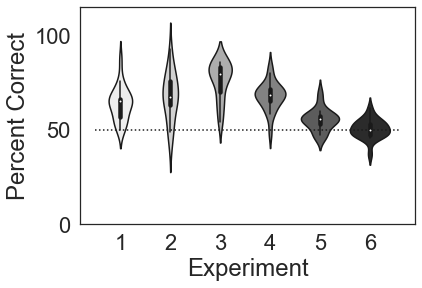



###################################################

Experiment 6

# Version: Experiment 6 ####
Mean: 50.5
Standard Error: 1.146024745591497

Mean t-test: TtestResult(statistic=0.43629075368868736, pvalue=0.6675430482825779, df=19)


###################################################

Experiment 3

# Version: Experiment 3 ####
Mean: 76.14285714285715
Standard Error: 2.249477800721725

Mean t-test: TtestResult(statistic=11.621744893178965, pvalue=4.44158418604534e-10, df=19)


###################################################

Experiment 5

# Version: Experiment 5 ####
Mean: 55.42857142857143
Standard Error: 1.3215555720316023

Mean t-test: TtestResult(statistic=4.107713321677564, pvalue=0.0005991017148643611, df=19)


###################################################

Experiment 4

# Version: Experiment 4 ####
Mean: 67.85714285714286
Standard Error: 1.6791512356486693

Mean t-test: TtestResult(statistic=10.634624492441565, pvalue=1.935931660651474e-09, df=19)


#################

In [107]:
mean_plot = full_data.groupby(['version','ID'], as_index=False).mean()

mean_plot['Experiment']   = np.nan
mean_plot.loc[mean_plot['version']=='Scrambled Order versus Veridical (Image)','Experiment'] = 'Experiment 1'
mean_plot.loc[mean_plot['version']=='Scrambled Order versus Veridical (Black)','Experiment'] = 'Experiment 2'
mean_plot.loc[mean_plot['version']=='Mismatched Image','Experiment'] = 'Experiment 3'
mean_plot.loc[mean_plot['version']=='Reverse Order versus Veridical (Image)','Experiment']   = 'Experiment 4'
mean_plot.loc[mean_plot['version']=='Reverse Order versus Veridical (Black)','Experiment']   = 'Experiment 5'

mean_plot.loc[mean_plot['version']=='Horizontal Flip versus Veridical (Black)','Experiment'] = 'Experiment 6'

exp_list = ['Experiment 1','Experiment 2','Experiment 3','Experiment 4','Experiment 5','Experiment 6']

p = sb.violinplot(data=mean_plot[mean_plot['Experiment'].isin(exp_list)],
              x='Experiment',y='Percent Correct',
             order = exp_list,
                 palette='Greys')

p.set_xticklabels(['1','2','3','4','5','6'])

p.hlines(50, -.5, 5.6, colors='k', linestyles='dotted')
p.set_ylim(0,115)

plt.savefig('figures/figure_3.pdf',bbox_inches='tight')
print(); print(); plt.show(); print()

# Stats for each experiment version
for e in mean_plot['Experiment'].unique():
    if type(e)==str:

        # Stats 
        print()
        print('###################################################')
        print()
        print(e)
        print()
        print('# Version: '+e+' ####')
        print('Mean: '+str(mean_plot[mean_plot['Experiment']==e]['Percent Correct'].mean()))
        print('Standard Error: '+str(scipy.stats.sem(mean_plot[mean_plot['Experiment']==e]['Percent Correct'])))
        print()
        print('Mean t-test: '+str(stats.ttest_1samp(a=list(mean_plot[mean_plot['Experiment']==e]['proportion_correct']), popmean=.5)))
        print()

# Checks

### Average Performance for Experiment 6

In [73]:
mean_plot[mean_plot['Experiment']=='Experiment 6'].mean()

trial_index              299.500000
time_elapsed          842451.856750
value                           NaN
correct_answer             0.493571
proportion_correct         0.505000
confidence                 0.952857
Unnamed: 0                      NaN
Percent Correct           50.500000
Confidence                 1.952857
dtype: float64

### Check Number of Participants per Experiment

In [74]:
g = mean_plot.groupby(['Experiment','ID'],as_index=False).mean()

for e in g['Experiment'].unique():
    print(len(g[g['Experiment']==e]['ID'].unique()))

20
21
20
20
20
20


### Check how many participants gave  lowest & highest rating (Exp1)

In [75]:
# this_data = full_data[full_data['version'] == 'Scrambled Order versus Veridical (Image)']
# c = this_data.groupby(['confidence','ID'],as_index=False).count()

# low_rating = list(c[c['confidence']==0.0]['ID'])
# high_rating = list(c[c['confidence']==3.0]['ID'])

In [76]:
# print(len(low_rating)==len(high_rating))
# print(len(low_rating)); print()

# print()


# for x in low_rating:
#     if x not in high_rating:
#         print('in low, but not high: ')
#         print(x)

# print()

# for x in high_rating:
#     if x not in low_rating:
#         print('in high, but not low: ')
#         print(x)

In [77]:
# this_data = full_data[full_data['version']=='Scrambled Order versus Veridical (Image)']
# prop_corr_list = list(this_data['proportion_correct'])
# prop_corr_shifted = prop_corr_list[2:]+[np.nan,np.nan]
# this_data['proportion_correct_shifted'] = prop_corr_shifted
# this_data['Percent correct'] = this_data['proportion_correct_shifted']*100
# p2  = this_data.groupby(['ID','image'],as_index=False).mean()

In [78]:
# sb.barplot(x='image',y='Percent correct', data=p2[p2['image'].str.contains('veridical')], palette='magma', ci=None)
# ax.set(ylabel='');
# ax.set(ylabel=None);
# ax.hlines(50, -1.5, 70, colors='k', linestyles='dotted')
# ax.set(ylim=(-50,150))
# ax.set(yticklabels=[])
# ax.set(xticklabels=[])
# ax.set(xlabel='Video Pair')
# plt.ylim(-50,200)
# plt.show()